In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import logsumexp
from matplotlib import cm
import arviz as az
import pymc as pm

# Assignment: Babies

In [2]:
babies = pd.read_csv('babies_month_length.csv')

In [3]:
month_obs = babies["Month"].values # x variable
length_obs = babies["Length"].values # y variable

## Problem and data

The length of human babies $y$ increase with the month from birth $x$ of the baby. For simplicity, we hypothize a *linear* dependency between $x$ and $y$, see scatterplot below.

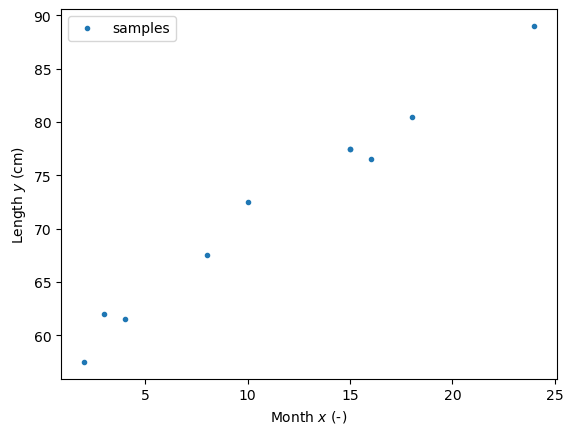

In [51]:
fig, ax = plt.subplots()
ax.plot(babies["Month"], babies["Length"], 'C0.', alpha=1.0, label="samples")
#ax.plot(0, alpha, "r*", label="alpha")
ax.set_ylabel("Length $y$ (cm)")
ax.set_xlabel("Month $x$ (-)")
plt.legend();

While the linear hypotesis seems reasonable, the points do not lie exactly on a line. In order to better characterize the data, we introduce the following probabilistic assumptions:



1. The average of the baby length $y_{\mu}$ at a given month $x$ is linear with intercept and slope coefficients 
   $\alpha$ and $\beta$, respectively:  $$y_{\mu} = \alpha + \beta x$$

2. The actual baby length is Gaussian with mean $y_{\mu}$ and standard deviation $\sigma$
3. The prior probability of $\beta$ is Gaussian with mean $0$ and standard deviation $\sigma_\beta=0.5$
4. The prior probability of $\sigma$ is a Half-Normal with standard deviation $\sigma_\sigma=1.0$
5. The intercept coefficient $\alpha$ is considered known and equal to $55.0$
6. Probabilities of different observations are independent of each other, given  $\beta, \sigma$


Note: Condition 5 is rather artificial. It has been introduced here to limit the number of random variables and allow implementation of different approximate inference techniques.

In [52]:
# Probabilistic model constants
alpha = 55.0
sigma_sigma = 1.0
sigma_beta = 0.5

## 1.1: Probabilistic model

* Derive and comment the full probabilistic model.

## 1.2: Maximum Likelihood estimation 


* Derive an analytical expression of the log-likelihood function $\ell(\beta, \sigma) = \log P(y|\beta, \sigma)$.

\begin{align*}
\mathcal{l}(\beta, \sigma) = \prod_{i=1}^{n} N(y_i; 55 + \beta x_i, sigma)
\end{align*}

* Write a Python function corresponding to the log-likelihood function $\ell(\beta, \sigma)$. You may ignore additive factors which do not depend on $\beta, \sigma$.

In [53]:
import numpy as np

loglik = np.array()

TypeError: array() missing required argument 'object' (pos 0)

* Visualize the log-likelihood function $\ell(\beta, \sigma)$ in 2D

* Obtain the maximum likelihood estimate $\beta^{\rm ml}, \sigma^{\rm ml}$

Hint: choose a good point to initialize the optimization

* Visualize the log-likelihood together with the maximum likelihood estimate

* Visualize the *likelihood* function $\mathcal{L}(\sigma, \beta)$ in 2D up to a multiplicative constant

## 1.2: Maximum A Posteriori Estimation

* Derive an analytical expression of the posterior $f(\theta | y)$, up to a *multiplicative* factor that does not depend on $\beta, \sigma$. 

Hint: exploit the already-obtained likelihood and the functional form of the Gaussian pdf.

* Derive an analytical expression of the log-posterior $\log f(\theta | y)$, up to an *additive* factor that does not depend on $\beta, \sigma$. 


\begin{align*}
\mathcal{f}(\beta, \sigma \mid D) = p(\beta) p(\sigma) \prod_{i=1}^{n} N(y_i; 55 + \beta x_i, sigma)\\
log(\mathcal{f}(\beta, \sigma \mid D)) = log(p(\beta)) + log(p(\sigma)) + \sum_{i=1}^{n} N(y_i; 55 + \beta x_i, sigma)\\
\end{align*}

* Write the log-posterior (up to an additive factor) as Python functions.

* Compute the maximum a posteriore estimate $\beta^{\rm MAP}, \sigma^{\rm MAP}$.

* Visualize the MAP estimate together with the log-posterior in 2D. Comment the results.

## 1.3 Gridding (aka brute-force) posterior estimation

* Compute a gridding approximation of the *normalized* posterior, with the correct normalization constant. Explain the passages.

* Visualize the *normalized* posterior, together with the ML and MAP estimates

* Using the grid-based approximation of the posterior, compute the posterior mean of $\beta$ and $\sigma$.

This is yet another meaningful point estimate of the latent variables $\beta, \sigma$ 

## 1.4 Monte-carlo estimation

* Obtain a sample-based approximation of the posterior $f(\beta, \sigma | y)$ using pymc.

* Obtain a sample-based approximation of the posterior $f(\beta, \sigma | y)$ by implementing the Metropolis algorithm from scratch.

In [4]:
import pymc as pm
penguinModel = pm.Model()

with penguinModel:
    alpha = 55
    beta = pm.Normal('beta', mu=0, sigma=0.5)
    sigma = pm.HalfNormal('sigma',sigma=1)
    y = pm.Normal('y',mu=alpha + beta * month_obs, sigma=sigma, observed= length_obs)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


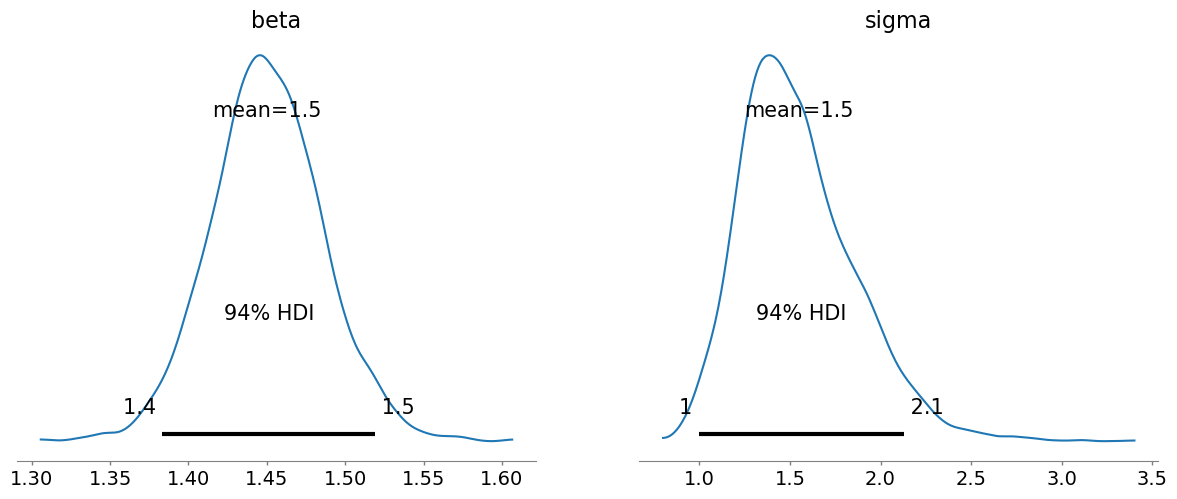

In [5]:
with penguinModel:
    az.plot_posterior(trace)

In [6]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,1.450,0.036,1.383,1.519,0.001,0.000,3242.0,2486.0,1.0
sigma,1.548,0.321,0.995,2.131,0.006,0.004,2929.0,2439.0,1.0


In [103]:
# computes the log-posterior for a specific parameter value and given the data set
def log_posterior (alpha, beta, sigma, x, y):
    #log prior
    log_beta = np.log( stats.norm.pdf(beta, loc=0, scale=0.5) )
    log_sigma = np.log( stats.halfnorm.pdf(sigma, scale=1) )
    log_prior = log_beta + log_sigma
    log_lik=0
    for i in (range(len(y))):
        log_lik = log_lik + stats.norm.pdf(y[i], loc = alpha + beta * x[i], scale = sigma)
    return (log_beta[0] + log_sigma[0] + log_lik[0])


In [104]:
#bivariate metropolis sampling
import scipy.stats as stats

samples=100
trace = np.zeros([samples,2])
logp_trace = np.zeros([samples])


#draw initial value
alpha = 55
sigma0 = stats.halfnorm.rvs(scale=1, size=1)
beta0  = stats.norm.rvs(loc=0, scale=0.5, size=1)
trace[0] = [beta0[0], sigma0[0]]
logp_trace[0] = log_posterior(alpha, beta0, sigma0, x=month_obs, y=length_obs) 

#for i in range(samples)
    #draw proposal
    #compute difference of log-posterior



In [78]:
trace = np.zeros([10,2])
trace[0] = [1, 2]
trace[0,0] = stats.norm.rvs(loc=0, scale=0.5, size=1)

/var/folders/2k/rgs_y6s556x557660m9wmrfc0000gp/T/ipykernel_8036/2485819306.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trace[0,0] = stats.norm.rvs(loc=0, scale=0.5, size=1)


In [102]:
log_posterior(alpha, beta0, sigma0, x=month_obs, y=length_obs) 

array([-0.76100387])